In [1]:
import pandas as pd
import numpy as np 

import statsmodels.formula.api as sm # module for stats models
from statsmodels.iolib.summary2 import summary_col # module for presenting stats models outputs nicely

In [2]:
def price2ret(prices,retType='simple'):
    if retType == 'simple':
        ret = (prices/prices.shift(1))-1
    else:
        ret = np.log(prices/prices.shift(1))
    return ret

In [3]:
def assetPriceReg(df_stk):
    import pandas_datareader.data as web  # module for reading datasets directly from the web
    
    # Reading in factor data
    df_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench')[0]
    df_factors.rename(columns={'Mkt-RF': 'MKT'}, inplace=True)
    df_factors['MKT'] = df_factors['MKT']/100
    df_factors['SMB'] = df_factors['SMB']/100
    df_factors['HML'] = df_factors['HML']/100
    df_factors['RMW'] = df_factors['RMW']/100
    df_factors['CMA'] = df_factors['CMA']/100
    
    df_stock_factor = pd.merge(df_stk,df_factors,left_index=True,right_index=True) # Merging the stock and factor returns dataframes together
    df_stock_factor['XsRet'] = df_stock_factor['Returns'] - df_stock_factor['RF'] # Calculating excess returns

    # Running CAPM, FF3, and FF5 models.
    CAPM = sm.ols(formula = 'XsRet ~ MKT', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    FF3 = sm.ols( formula = 'XsRet ~ MKT + SMB + HML', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    FF5 = sm.ols( formula = 'XsRet ~ MKT + SMB + HML + RMW + CMA', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})

    CAPMtstat = CAPM.tvalues
    FF3tstat = FF3.tvalues
    FF5tstat = FF5.tvalues

    CAPMcoeff = CAPM.params
    FF3coeff = FF3.params
    FF5coeff = FF5.params

    # DataFrame with coefficients and t-stats
    results_df = pd.DataFrame({'CAPMcoeff':CAPMcoeff,'CAPMtstat':CAPMtstat,
                               'FF3coeff':FF3coeff, 'FF3tstat':FF3tstat,
                               'FF5coeff':FF5coeff, 'FF5tstat':FF5tstat},
    index = ['Intercept', 'MKT', 'SMB', 'HML', 'RMW', 'CMA'])


    dfoutput = summary_col([CAPM,FF3, FF5],stars=True,float_format='%0.4f',
                  model_names=['CAPM','FF3','FF5'],
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'Adjusted R2':lambda x: "{:.4f}".format(x.rsquared_adj)}, 
                             regressor_order = ['Intercept', 'MKT', 'SMB', 'HML', 'RMW', 'CMA'])

    print(dfoutput)
    
    return results_df

In [4]:
from pathlib import Path
import sys
import os

home = str(Path.home())
print(home)

C:\Users\xz035


In [5]:


if sys.platform == 'linux':
    inputDir = '/datasets/stocks/' 
elif sys.platform == 'win32':
    inputDir = '\\datasets\stocks\\' 

fullDir = home+inputDir
print(fullDir)

C:\Users\xz035\datasets\stocks\


In [6]:
stkName = 'AAPL'
fileName = 'stk_' + stkName + '.csv'
readFile = fullDir+fileName 

df_stk = pd.read_csv(readFile,index_col='Date',parse_dates=True)
df_stk.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-02-12,23.547501,23.625000,23.252501,23.497499,21.855232,161405600
2016-02-16,23.754999,24.212500,23.652500,24.160000,22.471428,196231600
2016-02-17,24.167500,24.552500,24.037500,24.530001,22.815565,179452800
2016-02-18,24.709999,24.722500,24.022499,24.065001,22.383070,156084000
2016-02-19,24.000000,24.190001,23.950001,24.010000,22.331917,141496800


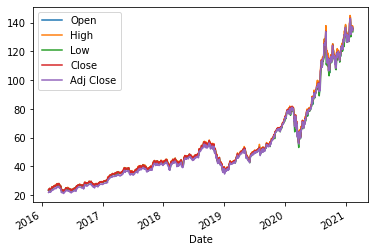

In [7]:
df_stk.drop(['Volume'],axis=1,inplace=True)
df_stk.plot()

In [8]:
df_stk['Returns'] = price2ret(df_stk[['Adj Close']])
df_stk = df_stk.dropna()
df_stk.head()

,Open,High,Low,Close,Adj Close,Returns
Date,,,,,,
2016-02-16,23.754999,24.212500,23.652500,24.160000,22.471428,0.028194
2016-02-17,24.167500,24.552500,24.037500,24.530001,22.815565,0.015314
2016-02-18,24.709999,24.722500,24.022499,24.065001,22.383070,-0.018956
2016-02-19,24.000000,24.190001,23.950001,24.010000,22.331917,-0.002285
2016-02-22,24.077499,24.225000,23.980000,24.219999,22.527231,0.008746


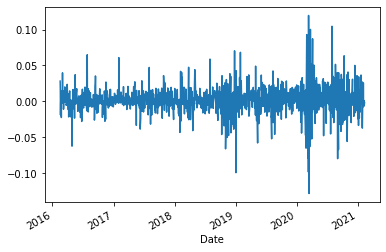

In [9]:
df_stk['Returns'].plot()

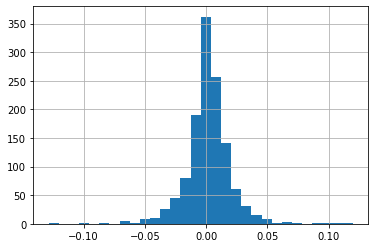

In [10]:
df_stk['Returns'].hist(bins=30)

In [11]:
df_regOutput = assetPriceReg(df_stk)


               CAPM       FF3        FF5    
--------------------------------------------
Intercept   -0.0035*** -0.0037*** -0.0038***
            (0.0004)   (0.0004)   (0.0004)  
MKT         1.1703***  1.2509***  1.2456*** 
            (0.0390)   (0.0355)   (0.0377)  
SMB                    -0.3046*** -0.2512***
                       (0.0706)   (0.0661)  
HML                    -0.4201*** -0.4720***
                       (0.0452)   (0.0578)  
RMW                               0.5240*** 
                                  (0.1017)  
CMA                               -0.1009   
                                  (0.1618)  
R-squared   0.5477     0.6088     0.6192    
            0.5481     0.6097     0.6208    
N           1230       1230       1230      
Adjusted R2 0.5477     0.6088     0.6192    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
